In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cpu

Training Q-Learning...
Episode 0, Reward: -324.70000000000005, Epsilon: 0.995, Time: 11.74s
Episode 100, Reward: -408.09999999999985, Epsilon: 0.603, Time: 780.08s
Early stopping at episode 180

Training Policy Gradient...
Episode 100, Reward: -150.9, Loss: 280.88, Time: 526.29s
Early stopping at episode 130

Testing Q-Learning Agent:
Test Episode 0, Reward: -235.7
Test Episode 1, Reward: -138.0
Test Episode 2, Reward: -228.60000000000002
Test Episode 3, Reward: -139.2
Test Episode 4, Reward: -188.3
Test Episode 5, Reward: -194.60000000000002
Test Episode 6, Reward: -172.3
Test Episode 7, Reward: -180.2
Test Episode 8, Reward: -161.79999999999998
Test Episode 9, Reward: -182.5
Average Test Reward: -182.12, Success Rate: 0.0%

Testing Policy Gradient Agent:
Test Episode 0, Reward: -191.09999999999997
Test Episode 1, Reward: -133.2
Test Episode 2, Reward: -169.8
Test Episode 3, Reward: -183.3
Test Episode 4, Reward: -173.5
Test Episode 5, Reward: -203.39999999999998
Te

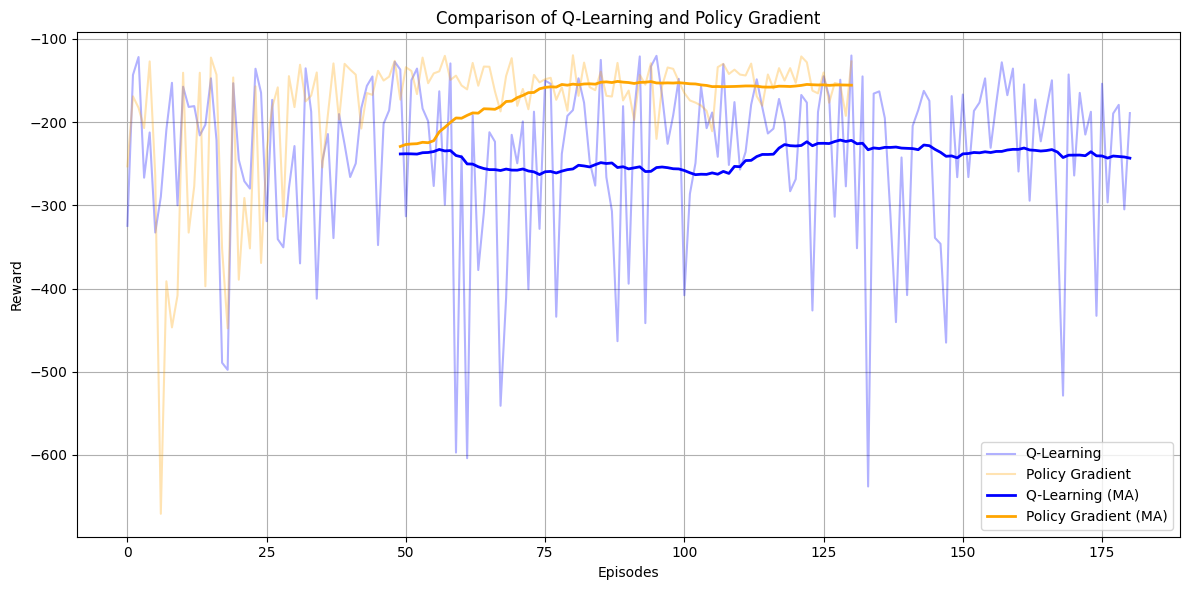

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import warnings
from typing import Tuple, List, Dict, Optional
import os
from pathlib import Path
import time

warnings.filterwarnings('ignore')

# Define a named tuple for experience replay
Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done'])

# Enhanced configuration
config = {
    # Training parameters
    "episodes": 2000,
    "gamma": 0.99,
    "learning_rate": 0.01,

    # Q-Learning parameters
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay": 0.995,
    "target_update_freq": 100,

    # Policy Gradient parameters
    "baseline_enabled": True,
    "grad_clip": 0.5,
    "value_loss_coef": 0.5,

    # Replay buffer
    "replay_buffer_size": 10000,
    "batch_size": 32,

    # Early stopping
    "patience": 50,

    # Network architecture
    "hidden_size": 128,

    # Environment
    "env_name": "FrozenLake-v1",
    "map_name": "8x8",
    "is_slippery": True,

    # Reward shaping
    "goal_reward": 100,
    "hole_penalty": -100,
    "step_penalty": -0.1,
    "distance_factor": 0.1,

    # Logging and saving
    "log_dir": "runs",
    "save_dir": "saved_models",
    "save_interval": 100,

    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

class FrozenLakeWrapper(gym.Wrapper):
    """Wrapper that handles both old and new Gym API versions."""
    def __init__(self, env: gym.Env):
        super().__init__(env)
        self.original_observation_space = env.observation_space
        self.original_action_space = env.action_space

    def reset(self) -> int:
        state = super().reset()
        return state[0] if isinstance(state, tuple) else state

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        result = super().step(action)
        if len(result) == 5:  # New Gym API (v0.26+)
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
            return next_state, reward, done, info
        else:  # Old Gym API
            next_state, reward, done, info = result
            return next_state, reward, done, info

class ReplayBuffer:
    """Experience replay buffer with fixed capacity."""
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state: int, action: int, reward: float,
             next_state: int, done: bool) -> None:
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> List[Experience]:
        return random.sample(self.buffer, batch_size)

    def __len__(self) -> int:
        return len(self.buffer)

class PolicyNetwork(nn.Module):
    """Policy network with value function baseline."""
    def __init__(self, input_dim: int, output_dim: int,
                 hidden_size: int = 128, device: str = "cpu"):
        super().__init__()
        self.device = torch.device(device)
        self.shared_layer = nn.Linear(input_dim, hidden_size)
        self.policy_head = nn.Linear(hidden_size, output_dim)
        self.value_head = nn.Linear(hidden_size, 1)
        self.to(self.device)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = torch.relu(self.shared_layer(x))
        return torch.softmax(self.policy_head(x), dim=-1), self.value_head(x)

def q_learning(env: FrozenLakeWrapper, num_episodes: int = 1000,
               alpha: float = 0.1, gamma: float = 0.99) -> Tuple[np.ndarray, List[float]]:
    """Q-Learning with experience replay and double Q-learning."""
    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n
    q_table = np.zeros((n_states, n_actions))
    target_q_table = q_table.copy()
    buffer = ReplayBuffer(config["replay_buffer_size"])
    rewards = []
    epsilon = config["epsilon_start"]
    best_reward = -np.inf
    no_improve = 0

    # Create directories if they don't exist
    Path(config["log_dir"]).mkdir(parents=True, exist_ok=True)
    Path(config["save_dir"]).mkdir(parents=True, exist_ok=True)

    writer = SummaryWriter(log_dir=os.path.join(config["log_dir"], "q_learning"))

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(env, state, action, next_state, done)
            buffer.push(state, action, reward, next_state, done)

            # Sample from replay buffer
            if len(buffer) >= config["batch_size"]:
                batch = buffer.sample(config["batch_size"])
                for exp in batch:
                    # Double Q-learning update
                    next_action = np.argmax(q_table[exp.next_state])
                    target = exp.reward + gamma * target_q_table[exp.next_state, next_action] * (1 - exp.done)
                    q_table[exp.state, exp.action] += alpha * (target - q_table[exp.state, exp.action])

            state = next_state
            total_reward += reward

        # Update target network periodically
        if episode % config["target_update_freq"] == 0:
            target_q_table = q_table.copy()

        # Epsilon decay
        epsilon = max(config["epsilon_end"], epsilon * config["epsilon_decay"])

        rewards.append(total_reward)
        writer.add_scalar('Reward', total_reward, episode)

        # Early stopping
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
            # Save best Q-table
            np.save(os.path.join(config["save_dir"], "best_q_table.npy"), q_table)
        else:
            no_improve += 1

        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break

        if episode % config["save_interval"] == 0:
            np.save(os.path.join(config["save_dir"], f"q_table_ep_{episode}.npy"), q_table)

        if episode % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Episode {episode}, Reward: {total_reward}, "
                  f"Epsilon: {epsilon:.3f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    writer.close()
    return q_table, rewards

def train_policy_gradient(env: FrozenLakeWrapper, policy_net: PolicyNetwork,
                         optimizer: optim.Optimizer, num_episodes: int = 1000) -> List[float]:
    """Policy gradient with advantage normalization and learning rate scheduling."""
    n_states = env.original_observation_space.n
    rewards = []
    best_reward = -np.inf
    no_improve = 0

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    writer = SummaryWriter(log_dir=os.path.join(config["log_dir"], "policy_gradient"))

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()
        episode_rewards = []
        episode_log_probs = []
        episode_values = []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(np.eye(n_states)[state]).to(config["device"])
            action_probs, value = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward_function(env, state, action.item(), next_state, done)

            episode_log_probs.append(action_dist.log_prob(action))
            episode_rewards.append(reward)
            episode_values.append(value)

            state = next_state

        # Calculate discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + config["gamma"] * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards,
                                       dtype=torch.float32,
                                       device=config["device"])

        # Calculate advantages with baseline
        values = torch.cat(episode_values).squeeze()
        advantages = discounted_rewards - values.detach()

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Calculate policy loss
        policy_loss = torch.stack([
            -log_prob * advantage
            for log_prob, advantage in zip(episode_log_probs, advantages)
        ]).sum()

        # Calculate value loss
        value_loss = nn.MSELoss()(values, discounted_rewards)

        # Total loss
        loss = policy_loss + config["value_loss_coef"] * value_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), config["grad_clip"])
        optimizer.step()

        # Learning rate scheduling
        if episode % 100 == 0:
            scheduler.step()

        total_reward = sum(episode_rewards)
        rewards.append(total_reward)

        writer.add_scalar('Reward', total_reward, episode)
        writer.add_scalar('Loss', loss.item(), episode)
        writer.add_scalar('Policy Loss', policy_loss.item(), episode)
        writer.add_scalar('Value Loss', value_loss.item(), episode)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], episode)

        # Early stopping and model saving
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
            torch.save({
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'reward': best_reward,
                'episode': episode
            }, os.path.join(config["save_dir"], "best_policy_model.pth"))
        else:
            no_improve += 1

        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break

        if episode % config["save_interval"] == 0:
            torch.save({
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'reward': total_reward,
                'episode': episode
            }, os.path.join(config["save_dir"], f"policy_model_ep_{episode}.pth"))

        if (episode + 1) % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Episode {episode+1}, Reward: {total_reward}, "
                  f"Loss: {loss.item():.2f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    writer.close()
    return rewards

def custom_reward_function(env: FrozenLakeWrapper, state: int, action: int,
                          next_state: int, done: bool) -> float:
    """Custom reward function with distance-based shaping."""
    goal_state = env.original_observation_space.n - 1

    if done:
        return config["goal_reward"] if next_state == goal_state else config["hole_penalty"]

    distance_to_goal = abs(goal_state - next_state)
    return (-config["distance_factor"] * distance_to_goal +
            config["step_penalty"])

def test_agent(env: FrozenLakeWrapper, policy_net: Optional[PolicyNetwork] = None,
               q_table: Optional[np.ndarray] = None, num_episodes: int = 10,
               render: bool = False) -> float:
    """Test an agent with optional rendering."""
    n_states = env.original_observation_space.n
    rewards = []
    success_rate = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if render:
                env.render()
                time.sleep(0.1)

            if policy_net is not None:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(np.eye(n_states)[state]).to(config["device"])
                    action_probs, _ = policy_net(state_tensor)
                    action = torch.argmax(action_probs).item()
            elif q_table is not None:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(env, state, action, next_state, done)
            state = next_state

        # Check if reached goal
        if state == env.original_observation_space.n - 1:
            success_rate += 1

        rewards.append(total_reward)
        print(f"Test Episode {episode}, Reward: {total_reward}")

    avg_reward = np.mean(rewards)
    success_rate = success_rate / num_episodes * 100
    print(f"Average Test Reward: {avg_reward:.2f}, Success Rate: {success_rate:.1f}%")
    return avg_reward

def plot_results(q_rewards: List[float], pg_rewards: List[float]) -> None:
    """Plot training results with moving averages."""
    plt.figure(figsize=(12, 6))

    # Plot raw rewards
    plt.plot(q_rewards, label="Q-Learning", alpha=0.3, color='blue')
    plt.plot(pg_rewards, label="Policy Gradient", alpha=0.3, color='orange')

    # Calculate and plot moving averages
    window_size = 50
    q_moving_avg = np.convolve(q_rewards, np.ones(window_size)/window_size, mode='valid')
    pg_moving_avg = np.convolve(pg_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.plot(range(window_size-1, len(q_rewards)), q_moving_avg,
             label="Q-Learning (MA)", linewidth=2, color='blue')
    plt.plot(range(window_size-1, len(pg_rewards)), pg_moving_avg,
             label="Policy Gradient (MA)", linewidth=2, color='orange')

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Comparison of Q-Learning and Policy Gradient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save and show plot
    plot_path = os.path.join(config["log_dir"], "training_comparison.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Saved training plot to {plot_path}")
    plt.show()

if __name__ == "__main__":
    print(f"Using device: {config['device']}")

    # Create and wrap environment
    try:
        base_env = gym.make(
            config["env_name"],
            is_slippery=config["is_slippery"],
            map_name=config["map_name"],
            render_mode="human"  # For visualization if needed
        )
        env = FrozenLakeWrapper(base_env)
    except Exception as e:
        print(f"Error creating environment: {e}")
        exit(1)

    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n

    # Initialize networks and optimizers
    policy_net = PolicyNetwork(n_states, n_actions,
                             config["hidden_size"], config["device"])
    optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])

    # Train both agents
    print("\nTraining Q-Learning...")
    q_table, q_rewards = q_learning(env, num_episodes=config["episodes"])

    print("\nTraining Policy Gradient...")
    pg_rewards = train_policy_gradient(env, policy_net, optimizer,
                                      num_episodes=config["episodes"])

    # Test both agents
    print("\nTesting Q-Learning Agent:")
    q_test_reward = test_agent(env, q_table=q_table, render=False)

    print("\nTesting Policy Gradient Agent:")
    checkpoint = torch.load(os.path.join(config["save_dir"], "best_policy_model.pth"))
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    pg_test_reward = test_agent(env, policy_net=policy_net, render=False)

    # Compare performance
    print("\nFinal Comparison:")
    print(f"Q-Learning Average Reward (last 100 episodes): {np.mean(q_rewards[-100:]):.2f}")
    print(f"Policy Gradient Average Reward (last 100 episodes): {np.mean(pg_rewards[-100:]):.2f}")
    print(f"Q-Learning Test Reward: {q_test_reward:.2f}")
    print(f"Policy Gradient Test Reward: {pg_test_reward:.2f}")

    # Plot results
    plot_results(q_rewards, pg_rewards)

Using device: cpu

Training Q-Learning...
Episode 0, Reward: -294.49999999999994, Epsilon: 0.995, Time: 10.80s
Episode 100, Reward: -179.1, Epsilon: 0.603, Time: 785.09s
Early stopping at episode 125

Final Q-table:
State Left    Down    Right   Up      
0     -14.37  -13.93  -13.89  -14.86  
1     -13.13  -12.97  -12.94  -13.33  
2     -13.37  -13.00  -12.67  -12.68  
3     -11.53  -11.52  -11.44  -11.99  
4     -11.38  -11.59  -11.41  -11.62  
5     -11.17  -11.21  -10.96  -11.47  
6     -11.10  -10.78  -10.67  -10.75  
7     -10.73  -10.13  -9.62   -11.13  
8     -13.50  -11.86  -12.77  -13.59  
9     -11.89  -13.07  -13.06  -12.32  
10    -11.65  -10.66  -10.86  -11.47  
11    -37.13  -37.84  -46.23  -11.46  
12    -10.45  -9.93   -9.91   -10.50  
13    -9.20   -9.50   -9.23   -10.55  
14    -8.90   -9.38   -9.69   -10.27  
15    -8.65   -9.85   -9.78   -10.06  
16    -11.58  -10.60  -10.78  -11.38  
17    -10.30  -10.15  -10.39  -11.75  
18    -11.29  -24.67  -57.53  -43.53  
19  

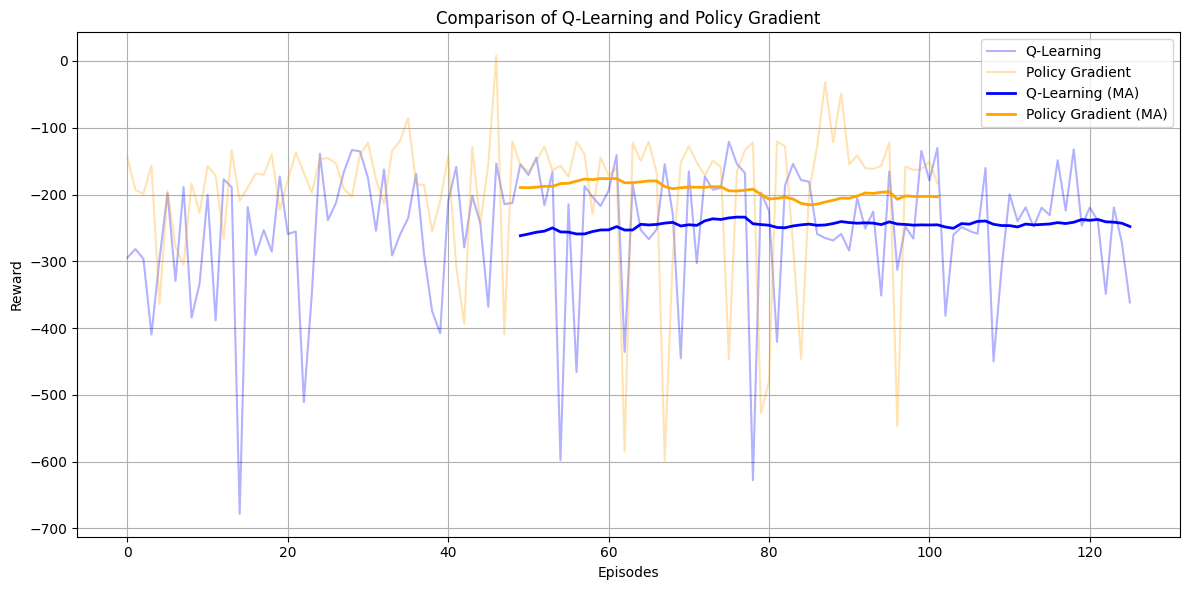

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import warnings
from typing import Tuple, List, Dict, Optional
import os
from pathlib import Path
import time

warnings.filterwarnings('ignore')

# Define a named tuple for experience replay
Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done'])

# Enhanced configuration
config = {
    # Training parameters
    "episodes": 2000,
    "gamma": 0.99,
    "learning_rate": 0.01,

    # Q-Learning parameters
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay": 0.995,
    "target_update_freq": 100,

    # Policy Gradient parameters
    "baseline_enabled": True,
    "grad_clip": 0.5,
    "value_loss_coef": 0.5,

    # Replay buffer
    "replay_buffer_size": 10000,
    "batch_size": 32,

    # Early stopping
    "patience": 50,

    # Network architecture
    "hidden_size": 128,

    # Environment
    "env_name": "FrozenLake-v1",
    "map_name": "8x8",
    "is_slippery": True,

    # Reward shaping
    "goal_reward": 100,
    "hole_penalty": -100,
    "step_penalty": -0.1,
    "distance_factor": 0.1,

    # Logging and saving
    "log_dir": "runs",
    "save_dir": "saved_models",
    "save_interval": 100,

    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

class FrozenLakeWrapper(gym.Wrapper):
    """Wrapper that handles both old and new Gym API versions."""
    def __init__(self, env: gym.Env):
        super().__init__(env)
        self.original_observation_space = env.observation_space
        self.original_action_space = env.action_space

    def reset(self) -> int:
        state = super().reset()
        return state[0] if isinstance(state, tuple) else state

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        result = super().step(action)
        if len(result) == 5:  # New Gym API (v0.26+)
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
            return next_state, reward, done, info
        else:  # Old Gym API
            next_state, reward, done, info = result
            return next_state, reward, done, info

class ReplayBuffer:
    """Experience replay buffer with fixed capacity."""
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state: int, action: int, reward: float,
             next_state: int, done: bool) -> None:
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> List[Experience]:
        return random.sample(self.buffer, batch_size)

    def __len__(self) -> int:
        return len(self.buffer)

class PolicyNetwork(nn.Module):
    """Policy network with value function baseline."""
    def __init__(self, input_dim: int, output_dim: int,
                 hidden_size: int = 128, device: str = "cpu"):
        super().__init__()
        self.device = torch.device(device)
        self.shared_layer = nn.Linear(input_dim, hidden_size)
        self.policy_head = nn.Linear(hidden_size, output_dim)
        self.value_head = nn.Linear(hidden_size, 1)
        self.to(self.device)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = torch.relu(self.shared_layer(x))
        return torch.softmax(self.policy_head(x), dim=-1), self.value_head(x)

def q_learning(env: FrozenLakeWrapper, num_episodes: int = 1000,
               alpha: float = 0.1, gamma: float = 0.99) -> Tuple[np.ndarray, List[float]]:
    """Q-Learning with experience replay and double Q-learning."""
    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n
    q_table = np.zeros((n_states, n_actions))
    target_q_table = q_table.copy()
    buffer = ReplayBuffer(config["replay_buffer_size"])
    rewards = []
    epsilon = config["epsilon_start"]
    best_reward = -np.inf
    no_improve = 0

    # Create directories if they don't exist
    Path(config["log_dir"]).mkdir(parents=True, exist_ok=True)
    Path(config["save_dir"]).mkdir(parents=True, exist_ok=True)

    writer = SummaryWriter(log_dir=os.path.join(config["log_dir"], "q_learning"))

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(env, state, action, next_state, done)
            buffer.push(state, action, reward, next_state, done)

            # Sample from replay buffer
            if len(buffer) >= config["batch_size"]:
                batch = buffer.sample(config["batch_size"])
                for exp in batch:
                    # Double Q-learning update
                    next_action = np.argmax(q_table[exp.next_state])
                    target = exp.reward + gamma * target_q_table[exp.next_state, next_action] * (1 - exp.done)
                    q_table[exp.state, exp.action] += alpha * (target - q_table[exp.state, exp.action])

            state = next_state
            total_reward += reward

        # Update target network periodically
        if episode % config["target_update_freq"] == 0:
            target_q_table = q_table.copy()

        # Epsilon decay
        epsilon = max(config["epsilon_end"], epsilon * config["epsilon_decay"])

        rewards.append(total_reward)
        writer.add_scalar('Reward', total_reward, episode)

        # Early stopping
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
            # Save best Q-table
            np.save(os.path.join(config["save_dir"], "best_q_table.npy"), q_table)
        else:
            no_improve += 1

        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break

        if episode % config["save_interval"] == 0:
            np.save(os.path.join(config["save_dir"], f"q_table_ep_{episode}.npy"), q_table)

        if episode % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Episode {episode}, Reward: {total_reward}, "
                  f"Epsilon: {epsilon:.3f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    writer.close()
    return q_table, rewards

def train_policy_gradient(env: FrozenLakeWrapper, policy_net: PolicyNetwork,
                         optimizer: optim.Optimizer, num_episodes: int = 1000) -> List[float]:
    """Policy gradient with advantage normalization and learning rate scheduling."""
    n_states = env.original_observation_space.n
    rewards = []
    best_reward = -np.inf
    no_improve = 0

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    writer = SummaryWriter(log_dir=os.path.join(config["log_dir"], "policy_gradient"))

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()
        episode_rewards = []
        episode_log_probs = []
        episode_values = []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(np.eye(n_states)[state]).to(config["device"])
            action_probs, value = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward_function(env, state, action.item(), next_state, done)

            episode_log_probs.append(action_dist.log_prob(action))
            episode_rewards.append(reward)
            episode_values.append(value)

            state = next_state

        # Calculate discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + config["gamma"] * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards,
                                       dtype=torch.float32,
                                       device=config["device"])

        # Calculate advantages with baseline
        values = torch.cat(episode_values).squeeze()
        advantages = discounted_rewards - values.detach()

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Calculate policy loss
        policy_loss = torch.stack([
            -log_prob * advantage
            for log_prob, advantage in zip(episode_log_probs, advantages)
        ]).sum()

        # Calculate value loss
        value_loss = nn.MSELoss()(values, discounted_rewards)

        # Total loss
        loss = policy_loss + config["value_loss_coef"] * value_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), config["grad_clip"])
        optimizer.step()

        # Learning rate scheduling
        if episode % 100 == 0:
            scheduler.step()

        total_reward = sum(episode_rewards)
        rewards.append(total_reward)

        writer.add_scalar('Reward', total_reward, episode)
        writer.add_scalar('Loss', loss.item(), episode)
        writer.add_scalar('Policy Loss', policy_loss.item(), episode)
        writer.add_scalar('Value Loss', value_loss.item(), episode)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], episode)

        # Early stopping and model saving
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
            torch.save({
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'reward': best_reward,
                'episode': episode
            }, os.path.join(config["save_dir"], "best_policy_model.pth"))
        else:
            no_improve += 1

        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break

        if episode % config["save_interval"] == 0:
            torch.save({
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'reward': total_reward,
                'episode': episode
            }, os.path.join(config["save_dir"], f"policy_model_ep_{episode}.pth"))

        if (episode + 1) % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Episode {episode+1}, Reward: {total_reward}, "
                  f"Loss: {loss.item():.2f}, Time: {elapsed:.2f}s")
            start_time = time.time()

    writer.close()
    return rewards

def custom_reward_function(env: FrozenLakeWrapper, state: int, action: int,
                          next_state: int, done: bool) -> float:
    """Custom reward function with distance-based shaping."""
    goal_state = env.original_observation_space.n - 1

    if done:
        return config["goal_reward"] if next_state == goal_state else config["hole_penalty"]

    distance_to_goal = abs(goal_state - next_state)
    return (-config["distance_factor"] * distance_to_goal +
            config["step_penalty"])

def test_agent(env: FrozenLakeWrapper, policy_net: Optional[PolicyNetwork] = None,
               q_table: Optional[np.ndarray] = None, num_episodes: int = 10,
               render: bool = False) -> float:
    """Test an agent with optional rendering."""
    n_states = env.original_observation_space.n
    rewards = []
    success_rate = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if render:
                env.render()
                time.sleep(0.1)

            if policy_net is not None:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(np.eye(n_states)[state]).to(config["device"])
                    action_probs, _ = policy_net(state_tensor)
                    action = torch.argmax(action_probs).item()
            elif q_table is not None:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(env, state, action, next_state, done)
            state = next_state

        # Check if reached goal
        if state == env.original_observation_space.n - 1:
            success_rate += 1

        rewards.append(total_reward)
        print(f"Test Episode {episode}, Reward: {total_reward}")

    avg_reward = np.mean(rewards)
    success_rate = success_rate / num_episodes * 100
    print(f"Average Test Reward: {avg_reward:.2f}, Success Rate: {success_rate:.1f}%")
    return avg_reward

def plot_results(q_rewards: List[float], pg_rewards: List[float]) -> None:
    """Plot training results with moving averages."""
    plt.figure(figsize=(12, 6))

    # Plot raw rewards
    plt.plot(q_rewards, label="Q-Learning", alpha=0.3, color='blue')
    plt.plot(pg_rewards, label="Policy Gradient", alpha=0.3, color='orange')

    # Calculate and plot moving averages
    window_size = 50
    q_moving_avg = np.convolve(q_rewards, np.ones(window_size)/window_size, mode='valid')
    pg_moving_avg = np.convolve(pg_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.plot(range(window_size-1, len(q_rewards)), q_moving_avg,
             label="Q-Learning (MA)", linewidth=2, color='blue')
    plt.plot(range(window_size-1, len(pg_rewards)), pg_moving_avg,
             label="Policy Gradient (MA)", linewidth=2, color='orange')

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Comparison of Q-Learning and Policy Gradient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save and show plot
    plot_path = os.path.join(config["log_dir"], "training_comparison.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Saved training plot to {plot_path}")
    plt.show()

def print_q_table(q_table: np.ndarray):
    """Print the Q-table in a formatted table."""
    actions = ["Left", "Down", "Right", "Up"]

    # Print header
    print("{:<6}".format("State"), end="")
    for action in actions:
        print("{:<8}".format(action), end="")
    print()

    # Print each state's action values
    for state in range(len(q_table)):
        print("{:<6}".format(state), end="")
        for action in range(len(actions)):
            print("{:<8.2f}".format(q_table[state, action]), end="")
        print()

def print_policy_probs(policy_net: PolicyNetwork, n_states: int):
    """Print the policy network's action probabilities in a formatted table."""
    actions = ["Left", "Down", "Right", "Up"]

    # Print header
    print("{:<6}".format("State"), end="")
    for action in actions:
        print("{:<8}".format(action), end="")
    print()

    # Get probabilities for each state
    policy_net.eval()
    with torch.no_grad():
        for state in range(n_states):
            state_tensor = torch.FloatTensor(np.eye(n_states)[state]).to(config["device"])
            action_probs, _ = policy_net(state_tensor)
            probs = action_probs.cpu().numpy()

            print("{:<6}".format(state), end="")
            for prob in probs:
                print("{:<8.2f}".format(prob), end="")
            print()

if __name__ == "__main__":
    print(f"Using device: {config['device']}")

    # Create and wrap environment
    try:
        base_env = gym.make(
            config["env_name"],
            is_slippery=config["is_slippery"],
            map_name=config["map_name"],
            render_mode="human"  # For visualization if needed
        )
        env = FrozenLakeWrapper(base_env)
    except Exception as e:
        print(f"Error creating environment: {e}")
        exit(1)

    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n

    # Initialize networks and optimizers
    policy_net = PolicyNetwork(n_states, n_actions,
                             config["hidden_size"], config["device"])
    optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])

    # Train both agents
    print("\nTraining Q-Learning...")
    q_table, q_rewards = q_learning(env, num_episodes=config["episodes"])

    print("\nFinal Q-table:")
    print_q_table(q_table)

    print("\nTraining Policy Gradient...")
    pg_rewards = train_policy_gradient(env, policy_net, optimizer,
                                      num_episodes=config["episodes"])

    print("\nPolicy Network Action Probabilities:")
    print_policy_probs(policy_net, n_states)

    # Test both agents
    print("\nTesting Q-Learning Agent:")
    q_test_reward = test_agent(env, q_table=q_table, render=False)

    print("\nTesting Policy Gradient Agent:")
    checkpoint = torch.load(os.path.join(config["save_dir"], "best_policy_model.pth"))
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    pg_test_reward = test_agent(env, policy_net=policy_net, render=False)

    # Compare performance
    print("\nFinal Comparison:")
    print(f"Q-Learning Average Reward (last 100 episodes): {np.mean(q_rewards[-100:]):.2f}")
    print(f"Policy Gradient Average Reward (last 100 episodes): {np.mean(pg_rewards[-100:]):.2f}")
    print(f"Q-Learning Test Reward: {q_test_reward:.2f}")
    print(f"Policy Gradient Test Reward: {pg_test_reward:.2f}")

    # Plot results
    plot_results(q_rewards, pg_rewards)